In [1]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6xxx6_jp
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6xxx6_jp
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=57798660d6bea4f4bd79b45b83c731dcc9e8c4d8d1b459b9622224e9b8a6458d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5d2_v88n/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [2]:
!nvidia-smi

Tue Oct 10 19:00:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            3
    BogoMIPS:            4000.27
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowpref

In [4]:
%%cuda --name matmul.cu
#include <iostream>
#include <random>
#include "stdio.h"
#include "stdlib.h"
#include "cuda.h"
#include "curand.h"
#include <cublasXt.h>

// Fill the array A(nr_rows_A, nr_cols_A) with random numbers on GPU
void GPU_fill_rand(double *A, int nr_rows_A, int nr_cols_A) {
    // Create a pseudo-random number generator
    curandGenerator_t prng;
    curandCreateGenerator(&prng, CURAND_RNG_PSEUDO_DEFAULT);
    // Set the seed for the random number generator using the system clock
    curandSetPseudoRandomGeneratorSeed(prng, (unsigned long long) clock());
    // Fill the array with random numbers on the device
    curandGenerateUniformDouble(prng, A, nr_rows_A * nr_cols_A);
}

// Multiply the arrays A and B on GPU and save the result in C
// C(m,n) = A(m,k) * B(k,n)
void gpu_blas_mmul(const double *A, const double *B, double *C, const int m, const int k, const int n) {
    int lda=m,ldb=k,ldc=m;
    const double alf = 1;
    const double bet = 0;
    const double *alpha = &alf;
    const double *beta = &bet;
    // Create a handle for CUBLAS
    cublasHandle_t handle;
    cublasCreate(&handle);
    // Do the actual multiplication
    // I switch the parameters A and B to be handled has column major
    cublasDgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, m, n, k, alpha, B, ldb, A, lda, beta, C, ldc);
    // Destroy the handle
    cublasDestroy(handle);
}

void cpp_cpu_mmul(const double *A, const double *B, double *C, const int N) {
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            C[i * N + j] = 0.0;
            for (int k = 0; k < N; ++k)
                C[i * N + j] += A[i * N + k] * B[k * N + j];
        }
    }
}

double differ(double *A, double *B, const int N) {
    double diff = 0.0;
    for (int i = 0; i < N; ++i) {
        for (int j = 0; j < N; ++j) {
            diff += abs (A[i * N + j] - B[i * N + j]);
        }
    }
    return diff;
}

int main(int argc, char *argv[]) {

    int N = atoi(argv[1]);
    double start, end, gpu_time, cpu_time;

    // allocate 4 arrays on cpu
    double *h_A = (double *)malloc(N * N * sizeof(double));
    double *h_B = (double *)malloc(N * N * sizeof(double));
    double *h_C = (double *)malloc(N * N * sizeof(double)); //mem for gpu result
    double *cpu_C = (double *)malloc(N * N * sizeof(double)); //mem for cpu result

    // allocate 3 arrays on gpu
    double *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, N * N * sizeof(double));
    cudaMalloc(&d_B, N * N * sizeof(double));
    cudaMalloc(&d_C, N * N * sizeof(double));

    // fill arrs on gpu with random numbers
    GPU_fill_rand(d_A, N, N);
    GPU_fill_rand(d_B, N, N);

    // cp gpu data to cpu
    cudaMemcpy(h_A, d_A, N * N * sizeof(double),cudaMemcpyDeviceToHost);
    cudaMemcpy(h_B, d_B, N * N * sizeof(double),cudaMemcpyDeviceToHost);

    // mul on gpu
    start = clock();
    gpu_blas_mmul(d_A, d_B, d_C, N, N, N);
    end = clock();
    gpu_time = (end - start) / CLOCKS_PER_SEC;

    // cp gpu results to mem
    cudaMemcpy(h_C, d_C, N * N * sizeof(double),cudaMemcpyDeviceToHost);

    // mul on cpu
    start = clock();
    cpp_cpu_mmul(h_A, h_B, cpu_C, N);
    end = clock();
    cpu_time = (end - start) / CLOCKS_PER_SEC;

    double diff = differ(h_C, cpu_C, N);

    std::cout << "diff is " << diff << std::endl;
    std::cout << "N = " << N << std::endl;
    std::cout << "cpu time (s) = " << cpu_time << std::endl;
    std::cout << "gpu time (s) = " << gpu_time << std::endl;

    //Free GPU memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    // Free CPU memory
    free(h_A);
    free(h_B);
    free(h_C);

    return 0;
}

'File written in /content/src/matmul.cu'

In [5]:
!nvcc -o /content/src/matmul /content/src/matmul.cu -lcurand -lcublas

In [6]:
!/content/src/matmul 200

diff is 6.51923e-10
N = 200
cpu time (s) = 0.037302
gpu time (s) = 0.630733


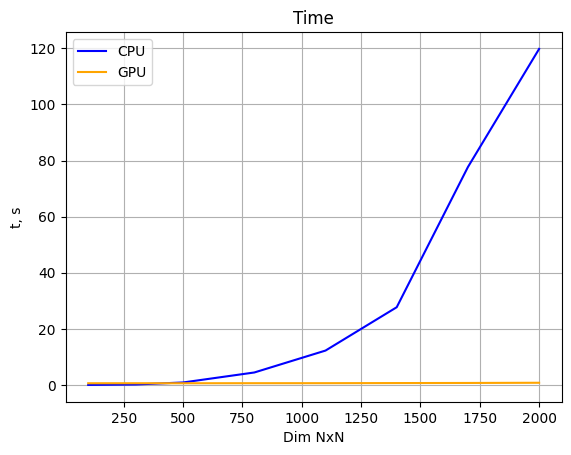

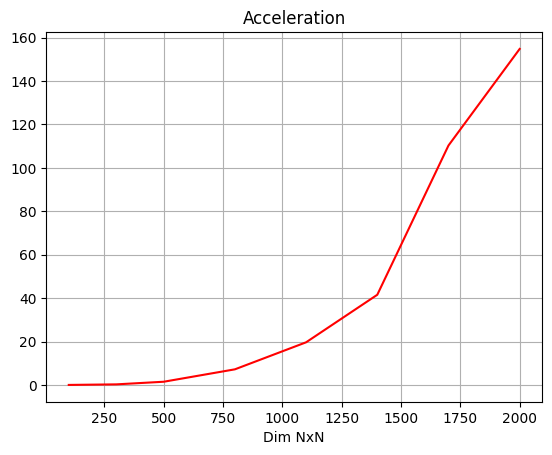

In [7]:
from matplotlib import pyplot as plt

sizes = [100, 300, 500, 800, 1100, 1400, 1700, 2000]
ctimes = [0.004792, 0.160246, 0.881748, 4.43985, 12.2533, 27.7016, 77.6709, 119.778]
gtimes = [0.601516, 0.608511, 0.598432, 0.617509, 0.623891, 0.666865, 0.704135, 0.773786]
accelerations = []
for i in range(len(sizes)):
    accelerations.append(ctimes[i] / gtimes[i])

plt.plot(sizes, ctimes, label='CPU', color='blue')
plt.plot(sizes, gtimes, label='GPU', color='orange')
plt.grid(True)
plt.legend()
plt.xlabel("Dim NxN")
plt.ylabel("t, s")
plt.title('Time')
plt.show()

plt.plot(sizes, accelerations, color='red')
plt.grid(True)
plt.xlabel("Dim NxN")
plt.title('Acceleration')
plt.show()